In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm

In [2]:
# defininf the states
# defininsg coefficeients sybols

def Creating_states(coeff, Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])

In [3]:
coeff = [1/(2**.5),1/(2**.5),1,0]

initial_states = Creating_states(coeff, Abstract=False)     # Creating the two states with these coefficients

psi0 = initial_states[0]
psi1 = initial_states[1]

print(coeff)
print(psi0,psi1)

[0.7071067811865475, 0.7071067811865475, 1, 0]
[0.7071067811865475, 0.7071067811865475] [1, 0]


In [4]:
psi0sq = []
psi1sq = []
[[psi0sq.append(i*j) for i in psi0] for j in psi0]
[[psi1sq.append(i*j) for i in psi1] for j in psi1]   # creating list of coeff for squared states (intermeditate step)

print(psi0sq, psi1sq)

psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

#psi0psi0 = [psi0sq[0], (psi0sq[1]+psi0sq[2]), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
#psi1psi1 = [psi1sq[0], (psi1sq[1]+psi1sq[2]), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

print(psi0psi0, psi1psi1)

# psi0psi0
# sum([i**2 for i in psi0psi0])   # adding to 1 now.

[0.4999999999999999, 0.4999999999999999, 0.4999999999999999, 0.4999999999999999] [1, 0, 0, 0]
[0.4999999999999999, 0.7071067811865474, 0.4999999999999999] [1, 0.0, 0]


In [5]:
psi0 = np.array(psi0)
psip0 = np.outer(psi0,psi0)
psps0 = np.kron(psip0,psip0)     # outer product of psi0 with itself
psi1 = np.array(psi1)
psip1 = np.outer(psi1,psi1)
psps1 = np.kron(psip1,psip1)     # outer product of psi0 with itself

rho_ex = (1/2)*(psps0+psps1)      # exact density matrix for the states - in the original 4-dim space

print(psps0)
print(psps1)
print(rho_ex)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0.625 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125]]


In [6]:
#creating the density matrix rho
# rho is 1/2*(|psi0psi0Xpsi0psi0|+|psi1psi1Xpsi1psi1|)
# findiing the conjugate vectors 

vec_psi0psi0 = np.array(psi0psi0)     # convertying to numpy arrays
vec_psi1psi1 = np.array(psi1psi1)

rho = (1/2)*(np.outer(vec_psi0psi0, vec_psi0psi0)+np.outer(vec_psi1psi1, vec_psi1psi1))       # density matrix with priors 1/2 each.

print(rho)
print(np.trace(rho))        # trace of rho is 1

[[0.625     0.1767767 0.125    ]
 [0.1767767 0.25      0.1767767]
 [0.125     0.1767767 0.125    ]]
0.9999999999999998


In [7]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

print([np.trace(POVM_elts[i]) for i in range(9)])  # trace of all 9 povms is the same - and not necessarily =1, which is ok
print(np.round(sum([POVM_elts[i] for i in range(9)])))  # sum of all povms is the identity matrix
# POVM_elts[0]

[(0.33333333333333326+0j), (0.33333333333333326+0j), (0.33333333333333326+0j), (0.33333333333333315+0j), (0.3333333333333332+0j), (0.3333333333333332+0j), (0.33333333333333315+0j), (0.3333333333333332+0j), (0.3333333333333332+0j)]
[[ 1.+0.j  0.-0.j  0.-0.j]
 [ 0.+0.j  1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j  1.+0.j]]


In [8]:
# prob_vec = [(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] #[(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]         # cleaned up the trailing imaginary parts

print(sum(prob_vec),prob_vec) # sum of probabilities is 1 and each probability is positive and <1
print(len(prob_vec))

0.9999999999999994 [0.0035744349011210316, 0.08333333333333333, 0.08690776823445436, 0.09196278254943938, 0.1458333333333333, 0.17529611588277272, 0.09196278254943938, 0.14583333333333326, 0.17529611588277275]
9


In [9]:
N = 10000       # number of measurements  

POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']       # symbols to indicate collapsed direction
#prob distribution is simply the corresponding elements of the prob_vec
collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
pj_num_vec = [i/N for i in nj_vec]         # working
#([i*N for i in prob_vec] , nj_vec)   # comparing the theoretical and experimental collapse probabilities

print(len(nj_vec))
print(pj_num_vec)
print(prob_vec)


9
[0.0023, 0.0812, 0.0877, 0.0939, 0.1414, 0.1737, 0.0923, 0.1477, 0.1798]
[0.0035744349011210316, 0.08333333333333333, 0.08690776823445436, 0.09196278254943938, 0.1458333333333333, 0.17529611588277272, 0.09196278254943938, 0.14583333333333326, 0.17529611588277275]


In [10]:
M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition


In [11]:
u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix
# np.trace(np.dot(M,M_inv))       # gives identity, checks out
r_vec = np.dot(M_inv,pj_num_vec)


In [12]:
rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
# [i for i in rho_num_list]

In [13]:
rho_num = np.zeros_like(rho_num_list[0])

# Loop over the matrices and sum them element-wise
for matrix in rho_num_list:
    rho_num = np.add(rho_num, matrix)

rho_num   

array([[0.623 +0.j        , 0.1781+0.01056551j, 0.1267-0.01091192j],
       [0.1781-0.01056551j, 0.2594+0.j        , 0.1816-0.00277128j],
       [0.1267+0.01091192j, 0.1816+0.00277128j, 0.1176+0.j        ]])

In [14]:
print(rho)
print(rho_num)

[[0.625     0.1767767 0.125    ]
 [0.1767767 0.25      0.1767767]
 [0.125     0.1767767 0.125    ]]
[[0.623 +0.j         0.1781+0.01056551j 0.1267-0.01091192j]
 [0.1781-0.01056551j 0.2594+0.j         0.1816-0.00277128j]
 [0.1267+0.01091192j 0.1816+0.00277128j 0.1176+0.j        ]]


In [15]:
rho # printing the theoretical density matrix and below the numerically reconstructed one
del_rho = rho_num-rho  # defining the difference of numberical and theoretical state
del_rho

array([[-0.002    +0.j        ,  0.0013233+0.01056551j,
         0.0017   -0.01091192j],
       [ 0.0013233-0.01056551j,  0.0094   +0.j        ,
         0.0048233-0.00277128j],
       [ 0.0017   +0.01091192j,  0.0048233+0.00277128j,
        -0.0074   +0.j        ]])

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
# eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue

# evals   Working till here

In [17]:
#Creating function for the deltarho error

def experiment_rho(N, coeff, priors):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
    
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    return error



0.011082412211964762


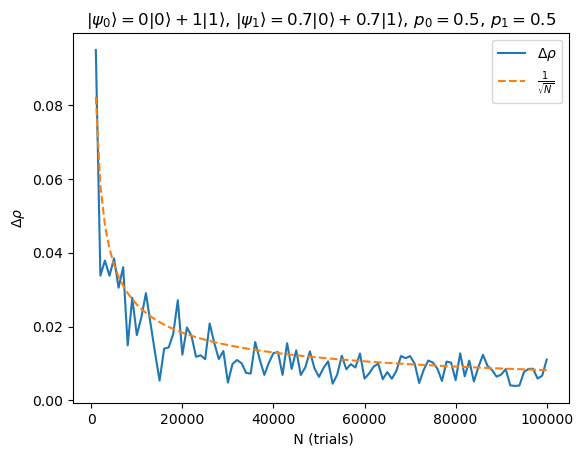

Error Converged to:  0.00887407713957068


In [18]:

coeff = [0,1,1/(2**.5),1/(2**.5)] #1/(2**.5)
priors = [.5,.5]
trials = [1000*(i+1) for i in range(100)]

sqrtN  = [2.6/(i**.5) for i in trials]     # ideal square root shape with a constant multiplied for scaling
errors = [experiment_rho(i,coeff,priors) for i in trials]
print(errors[-1])

plt.plot(trials, errors, label=r'$\Delta \rho $')
plt.plot(trials ,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
plt.xlabel(' N (trials)')
plt.ylabel(r'$\Delta \rho $')
plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={},\,p_1={}$'.format(round(coeff[0],1), round(coeff[1],1), round(coeff[2],1), round(coeff[3],1), priors[0], priors[1]))
plt.legend()

plt.show()

print(f'Error Converged to: ' , experiment_rho( 1000*100 ,coeff,priors))

In [19]:
# computing the error (fidelity) on the states directly 

eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
print(eigenvalues,eigenvectors)


# Find the index of the smallest eigenvalue
index = np.argmin(evals)

# Select the corresponding eigenvector
#eigenvector = eigenvectors[:, index]
eigenvector = eigenvectors[index]
print(eigenvector)

# coeffs of csi 
c00=eigenvector[0]
c01=eigenvector[1]
c11=eigenvector[2]

print(c00,c01,c11)

# def eq 5 in Hillery notes
#def quadratic_equation(x, a, b, c):
    #return a * x**2 + b * x + c

# solve eq 5 in Hillery notes
def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2
f0,f1=solve_quadratic(c00, 2*c01, c11)

# find coeff a0,1 and b0,1 for the states
a0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
a1 = 1/(m.sqrt(1+ (abs(f0))**2))
b0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
b1 = 1/(m.sqrt(1+ (abs(f1))**2))

# numerical states
psi0_num = [a0,a1]
psi1_num = [b0,b1]

# theoretical states
psi0 = [coeff[0],coeff[1]]
psi1 = [coeff[2],coeff[3]]

# fidelity
fid0 = abs(np.dot(psi0_num,psi0))**2
fid1 = abs(np.dot(psi1_num,psi1))**2
print(fid0,fid1)


[ 0.75272548-7.79313695e-19j  0.25413249+1.10477353e-18j
 -0.00685797+5.41901901e-19j] [[ 0.86035888+0.j         -0.50893356+0.0020199j  -0.00830262+0.02638593j]
 [ 0.41786085-0.0155904j   0.71505194+0.j         -0.56014491-0.00936223j]
 [ 0.29117743+0.01214714j  0.47863706-0.02428661j  0.82787975+0.j        ]]
[0.29117743+0.01214714j 0.47863706-0.02428661j 0.82787975+0.j        ]
(0.29117743147796327+0.012147142753388485j) (0.47863705550238084-0.02428660932107011j) (0.8278797497393696+0j)
0.18444006398865562 0.9782036830212243


In [20]:
#Creating function for the deltarho error

def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2

def experiment_fid(N, coeff, priors):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
     
    eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    index = np.argmin(evals)
    eigenvector = eigenvectors[:,index]
    c00=eigenvector[0]
    c01=eigenvector[1]
    c11=eigenvector[2]
    f0,f1=solve_quadratic(c00, 2*c01, c11)
    a0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
    a1 = 1/(m.sqrt(1+ (abs(f0))**2))
    b0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
    b1 = 1/(m.sqrt(1+ (abs(f1))**2))
    psi0_num = [a0,a1]
    psi1_num = [b0,b1]
    psi0 = [coeff[0],coeff[1]]
    psi1 = [coeff[2],coeff[3]]
    fid0 = abs(np.dot(psi0_num,psi0))**2
    fid1 = abs(np.dot(psi1_num,psi1))**2
    fid = [fid0,fid1]

    return [psi0_num,psi1_num,fid]

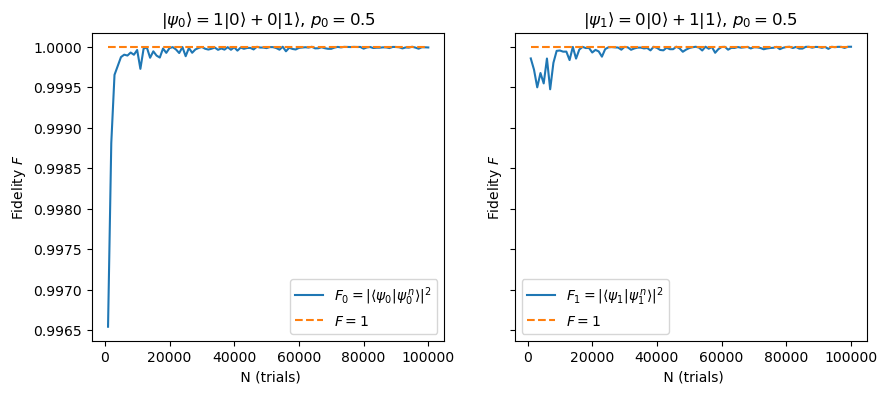

In [22]:
coeff = [1,0,0,1]
priors = [.5,.5]
trials = [1000*(i+1) for i in range(100)]

pfid  = [1 for i in trials]     # perfect fidelity of 1
error0 = [experiment_fid(i,coeff,priors)[2][0] for i in trials]
error1 = [experiment_fid(i,coeff,priors)[2][1] for i in trials]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1.plot(trials, error0, label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1.plot(trials , pfid, "--", label=r'$F=1$')
ax1.set_xlabel(' N (trials)')
ax1.set_ylabel(r'Fidelity $F$')
ax1.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1.legend(loc='best')

ax2.plot(trials, error1, label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2.plot(trials , pfid, "--", label=r'$F=1$')
ax2.set_xlabel(' N (trials)')
ax2.set_ylabel(r'Fidelity $F$')
ax2.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2.legend(loc='best')

plt.show()